# Time Series

[*********************100%%**********************]  2 of 2 completed


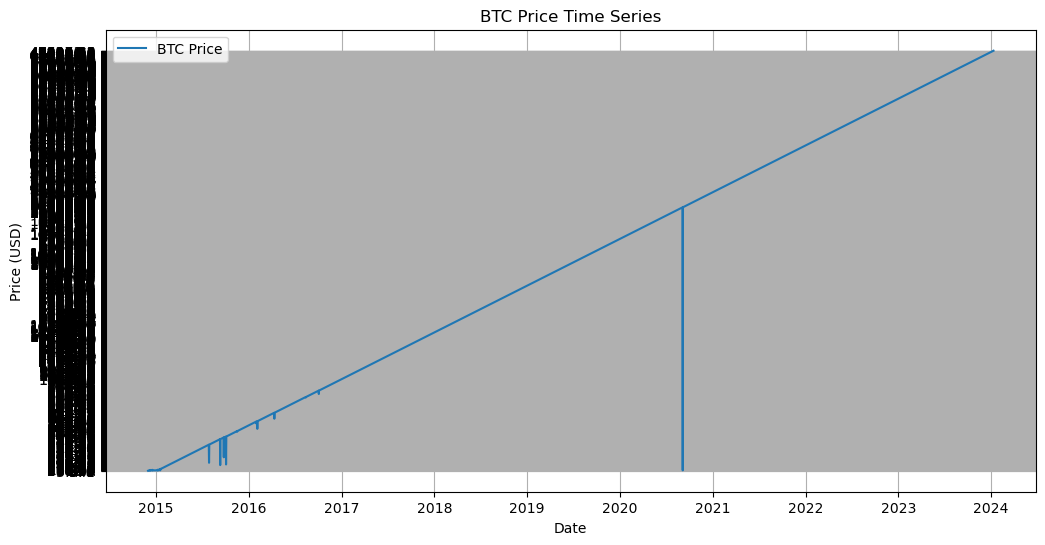

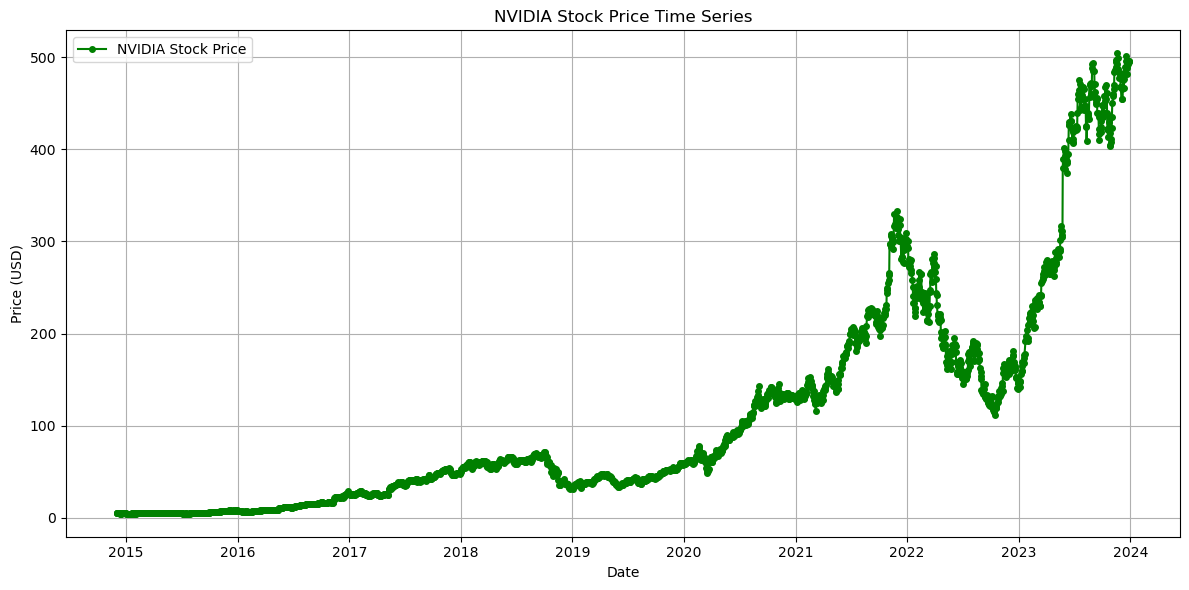

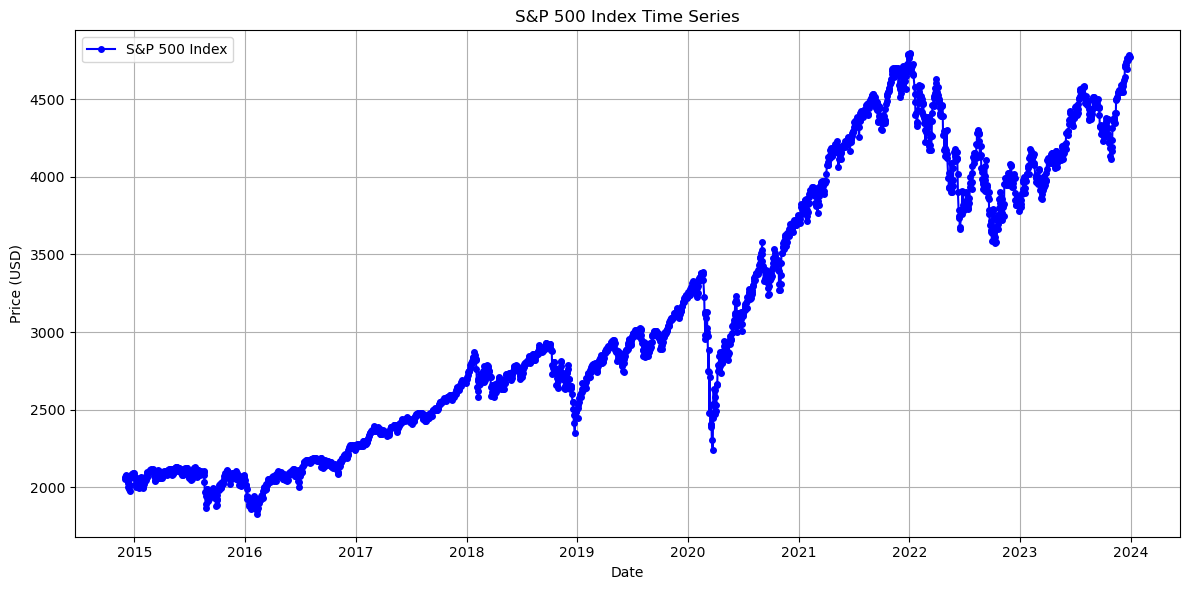

           BTC Price  Adj Close NVDA  Adj Close ^GSPC
Date                                                 
2014-12-01       370        4.940841      2053.439941
2014-12-02       378        4.948043      2066.550049
2014-12-03       378        5.075286      2074.330078
2014-12-04     377.1        5.029671      2071.919922
2014-12-05         .        5.058480      2075.370117
...              ...             ...              ...
2023-12-22   44015.6      488.299988      4754.629883
2023-12-26  42520.26      492.790009      4774.750000
2023-12-27  43444.45      494.170013      4781.580078
2023-12-28  42613.04      495.220001      4783.350098
2023-12-29   42056.3      495.220001      4769.830078

[2286 rows x 3 columns]
            BTC Price Returns  Adj Close NVDA Returns  Adj Close ^GSPC Returns
Date                                                                          
2014-12-01           0.000000                0.000000                 0.000000
2014-12-02           0.021622       

In [38]:
import yfinance as yf
import pandas as pd
import requests
import matplotlib.pyplot as plt

api_key = "a9c8f6c0d9575ab0191089f707776da6"
btc_series_id = 'CBBTCUSD'
api_url = f'https://api.stlouisfed.org/fred/series/observations?series_id={btc_series_id}&api_key={api_key}&file_type=json'

response = requests.get(api_url)
data = response.json()
observations = data['observations']
dates = [obs['date'] for obs in observations]
btc_prices = [obs['value'] for obs in observations]

btc_df = pd.DataFrame({'Date': dates, 'BTC Price': btc_prices})
btc_df['Date'] = pd.to_datetime(btc_df['Date'])
btc_df.set_index('Date', inplace=True)

tickers = ['NVDA', '^GSPC']
stocks = yf.download(tickers, start='2014-12-01', end='2024-01-01')['Adj Close']



together = pd.concat([btc_df['BTC Price'], stocks], axis=1)
together.columns = ['BTC Price', 'Adj Close NVDA', 'Adj Close ^GSPC']

together = together.dropna()

plt.figure(figsize=(12, 6))
plt.plot(btc_df.index, btc_df['BTC Price'], label='BTC Price')
plt.title('BTC Price Time Series')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

plt.close()

plt.figure(figsize=(12, 6))
plt.plot(together.index, together['Adj Close NVDA'], label='NVIDIA Stock Price', color='g', linestyle='-', marker='o', markersize=4)
plt.title('NVIDIA Stock Price Time Series')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.close()

plt.figure(figsize=(12, 6))
plt.plot(together.index, together['Adj Close ^GSPC'], label='S&P 500 Index', color='b', linestyle='-', marker='o', markersize=4)
plt.title('S&P 500 Index Time Series')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(together)

returns_df = pd.DataFrame()
for column in together.columns:
    together[column] = pd.to_numeric(together[column], errors='coerce')
    
    returns_df[column + ' Returns'] = (together[column] / together[column].shift(1) - 1).fillna(0)

print(returns_df)


# Data Analysis

In [45]:
import yfinance as yf
import pandas as pd
import requests
import statsmodels.api as sm


api_key = "a9c8f6c0d9575ab0191089f707776da6"
btc_series_id = 'CBBTCUSD'
api_url = f'https://api.stlouisfed.org/fred/series/observations?series_id={btc_series_id}&api_key={api_key}&file_type=json'

response = requests.get(api_url)
data = response.json()
observations = data['observations']
dates = [obs['date'] for obs in observations]
btc_prices = [float(obs['value']) if obs['value'] != '.' else None for obs in observations]

btc_df = pd.DataFrame({'Date': dates, 'BTC Price': btc_prices})
btc_df['Date'] = pd.to_datetime(btc_df['Date'])
btc_df.set_index('Date', inplace=True)

tickers = '^GSPC'
sp500 = yf.download(tickers, start='2014-12-01', end='2024-01-01')['Adj Close']

rfr = '^IRX'
rfrd = yf.download(rfr, start='2014-12-01', end='2024-01-01')['Adj Close'] / 100

frame = pd.concat([btc_df['BTC Price'], sp500, rfrd], axis=1)
frame.columns = ['BTC Price', 'Market Return', 'Risk-Free Rate']

frame = frame.dropna()

frame['BTC Price'] = pd.to_numeric(frame['BTC Price'], errors='coerce')

frame['Excess Return BTC'] = frame['BTC Price'].pct_change()
frame['Excess Return Market'] = frame['Market Return'].pct_change()

frame = frame.dropna(subset=['Excess Return BTC', 'Excess Return Market'])

X = sm.add_constant(frame['Excess Return Market'])
y = frame['Excess Return BTC']

model = sm.OLS(y, X)
regression = model.fit()


print(regression.summary())


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                            OLS Regression Results                            
Dep. Variable:      Excess Return BTC   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     80.39
Date:                Thu, 11 Jan 2024   Prob (F-statistic):           6.27e-19
Time:                        18:53:37   Log-Likelihood:                 3707.8
No. Observations:                2262   AIC:                            -7412.
Df Residuals:                    2260   BIC:                            -7400.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0029 

## Interpretation

From the Financial Modelling Module and from the Fundamentals of Financial Technology Module, we have learned that the constant should be zero for CAPM theory to be true. In the output we can see that the constant is nearly 0, so the strict CAPM theory holds. The coefficient for the excess market return is 0.7667 which means that the "Beta" of Bitcoin is 0.7667. This result means that Bitcoin is somewhat correlated with the S&P 500 index positively. As the Beta gets closer to 1, it gets more and more positively correlated with the index.